We need
- Image per frame
- convert to state
- give state as input

# 1. Import Dependencies

In [2]:
import gym                  # 0.26.2
import numpy as np          # 1.23.4
import tensorflow           # 2.13.0
import PIL                  # 10.1.0
import pygetwindow as gw    # 0.0.9
import pyautogui            # 0.9.54
import cv2                  # 4.8.1

from PIL import Image, ImageOps
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

print(f'gym: {gym.__version__}')
print(f'NumPy: {np.__version__}')
print(f'tensorflow: {tensorflow.__version__}')
print(f'Pillow: {PIL.__version__}')
print(f'pygetwindow: {gw.__version__}')
print(f'pyautogui: {gw.__version__}')
print(f'OpenCV2: {cv2.__version__}')

gym: 0.26.2
NumPy: 1.23.4
tensorflow: 2.13.0
Pillow: 10.1.0
pygetwindow: 0.0.9
pyautogui: 0.0.9
OpenCV2: 4.8.1


# 2. Create Environment

In [2]:
env = gym.make("CartPole-v0")
states = env.observation_space.shape[0]
actions = env.action_space.n
print(states)
print(actions)

4
2


c:\Users\kaan-\anaconda3\envs\gym38\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


# 3. Testing a random Agent
random agent gets an average score of 22, my goal is to crush that score

In [3]:
episodes = 5 # amount of runs
max_frames = 200 # max score
avg_score = 0
for episode in range(episodes):
    state = env.reset()
    dead = False
    score=0


    while not dead:
        env.render()
        action = env.action_space.sample()
        n_state, reward, dead, info, _ = env.step(action)
        score+=reward
    print(f'Episode:{episode} Score:{score}')
    avg_score+=score
print(avg_score/episodes)
env.close()

Episode:0 Score:40.0
Episode:1 Score:21.0
Episode:2 Score:21.0
Episode:3 Score:12.0
Episode:4 Score:31.0
25.0


c:\Users\kaan-\anaconda3\envs\gym38\lib\site-packages\gym\envs\classic_control\cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v0", render_mode="rgb_array")
  gym.logger.warn(


# Splitting Image up in Regions

In [4]:
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Parameters
THRESHOLD = 175
GRID_SIZE = 30

image_path = './data/pole.png'

# Open an image
loaded_image = Image.open(image_path)

# Grayscale the image
loaded_image = ImageOps.grayscale(loaded_image)

# Get the size (width x height)
width, height = loaded_image.size

# If you want to convert the image to a NumPy array
image_array = np.array(loaded_image)

# Assuming you have an input image 'image' with shape (height, width, channels)
height, width = image_array.shape
region_size = (height // GRID_SIZE, width // GRID_SIZE, 1)  # Change the channels to 1

# Split the image into 3x3 regions and extract only the red channel
regions = [image_array[i * region_size[0]: (i + 1) * region_size[0],
        j * region_size[1]: (j + 1) * region_size[1]]  # Select the red channel (index 0)
           for i in range(GRID_SIZE) for j in range(GRID_SIZE)]


# Convert the list of regions to a NumPy array
regions_array = np.array(regions)

# Create State

In [5]:
state = []

for region in regions_array:
    region_value = np.min(region)
    # print(region_value)
    if region_value < THRESHOLD:
        state.append(1)
    else:
        state.append(0)

# Add Grid

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import math

img = loaded_image

# Convert the image to a NumPy array
img_array = np.array(img)

# Plot the image
plt.imshow(img_array)

# Create a grid
grid_color = 'red'  # You can set the color of the grid lines
grid_size = round(loaded_image.width / 5)      # Set the size of the grid cells

# Get image dimensions
height, width = img_array.shape

# Create grid lines
for i in range(0, width, round(loaded_image.width / GRID_SIZE)):
    plt.plot([i, i], [0, height], color=grid_color, linewidth=1)

for j in range(0, height, round(loaded_image.height / GRID_SIZE)):
    plt.plot([0, width], [j, j], color=grid_color, linewidth=1)

# Optionally, you can add a border around the entire image
border = patches.Rectangle((0, 0), width, height,
                           linewidth=2, edgecolor='blue', facecolor='none')
plt.gca().add_patch(border)

# Display the image with the grid
plt.show()

NameError: name 'loaded_image' is not defined

# Visualize State

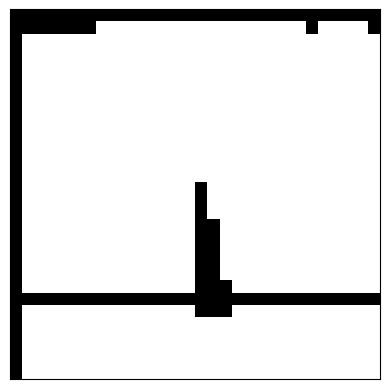

In [64]:
def visualize_binary_array(binary_array, grid_size):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    # Convert the binary array to a 2D numpy array
    array_2d = np.array(binary_array).reshape(-1, GRID_SIZE)

    # Create a colored grid
    plt.imshow(array_2d, cmap='Greys', interpolation='nearest')
    plt.show()

visualize_binary_array(state, GRID_SIZE)

# Define Agent

In [4]:
import pandas as pd
import random as rnd

class Agent():
    def __init__(self):
        self.state_array = []
        self.image_array = []

    def step(self, state):
        for element in self.state_array:
            if element[0] == state:
                print('i know what to do')
                return element[1]
        print('idk')
        return rnd.choice([0, 1])

    def learn(self, state, action, screenshot):
        # first check if the state is added already
        for element in self.state_array:
            if element[0] == state:
                return
        # learn state
        self.state_array.append([state, action])
        self.image_array.append(screenshot)

def get_screenshot(target_window):
    # Get the location and size of the window
    left, top, width, height = target_window.left, target_window.top, target_window.width, target_window.height

    # Capture the content of the window using pyautogui
    screenshot = pyautogui.screenshot(region=(left, top, width, height))
    # screenshot = cv2.cvtColor(np.array(screenshot), cv2.COLOR_RGB2BGR)
    return screenshot

def get_state(image):
    gray_image = ImageOps.grayscale(image)
    width, height = gray_image.size
    image_array = np.array(gray_image)
    height, width = image_array.shape
    region_size = (height // GRID_SIZE, width // GRID_SIZE, 1)

    # Split the image into 3x3 regions and extract only the red channel
    regions = [image_array[i * region_size[0]: (i + 1) * region_size[0],
                           j * region_size[1]: (j + 1) * region_size[1]]
               for i in range(GRID_SIZE) for j in range(GRID_SIZE)]

    # convert to np array
    regions_array = np.array(regions)

    # maximize and minimize values
    state=[]
    for region in regions_array:
        region_value = np.min(region)
        # print(region_value)
        if region_value < THRESHOLD:
            state.append(1)
        else:
            state.append(0)
    return state

# Building the environment loop, but making it possible to play myself

In [11]:
import keyboard
import time

env = gym.make("CartPole-v0", render_mode='human')
# agent = Agent()

GRID_SIZE = 30
THRESHOLD = 175
episodes = 1  # amount of runs
max_frames = 200  # max score
avg_score = 0
window_title = "pygame window"


for episode in range(episodes):
    state = env.reset()
    dead = False
    score = 0
    target_window = gw.getWindowsWithTitle(window_title) # get window
    target_window = target_window[0]

    while not dead:

        # Get state (cv2 shizzle)
        screenshot = get_screenshot(target_window)
        state = get_state(screenshot)

        # Config Controls
        timeout = 10 # wait for a keypress
        start_time = time.time()
        while time.time() - start_time < timeout:
            if keyboard.is_pressed('left'):
                action=0
                break
            elif keyboard.is_pressed('right'):
                action=1
                break

        # Learn from my gameplay
        agent.learn(state, action, screenshot)
        
        # Gym Game
        env.render()
        _, reward, dead, info, _ = env.step(action) # get action from player
        score += reward
    print(f'Episode:{episode} Score:{score}')
    avg_score += score
print(avg_score/episodes)
env.close()

Episode:0 Score:92.0
92.0


# Testing the Agent

In [17]:
import keyboard
import time

env = gym.make("CartPole-v0", render_mode='human')
# agent = Agent()

GRID_SIZE = 30
episodes = 1  # amount of runs
max_frames = 200  # max score
avg_score = 0
window_title = "pygame window"
screenshot_save = []


for episode in range(episodes):
    state = env.reset()
    dead = False
    score = 0
    target_window = gw.getWindowsWithTitle(window_title)  # get window
    target_window = target_window[0]

    while not dead:

        # Get state (cv2 shizzle)
        screenshot = get_screenshot(target_window)
        state = get_state(screenshot)


        # Gym Game
        env.render()
        _, reward, dead, info, _ = env.step(agent.step(state))  # get action from player
        score += reward
        screenshot_save = screenshot
    print(f'Episode:{episode} Score:{score}')
    avg_score += score
print(avg_score/episodes)
env.close()
print('last screenshot:')
plt.show(screenshot_save)

idk
idk
idk
idk
i know what to do
i know what to do
i know what to do
i know what to do
i know what to do
i know what to do
idk
idk
Episode:0 Score:12.0
12.0
last screenshot:


NameError: name 'plt' is not defined

# The frame before i died

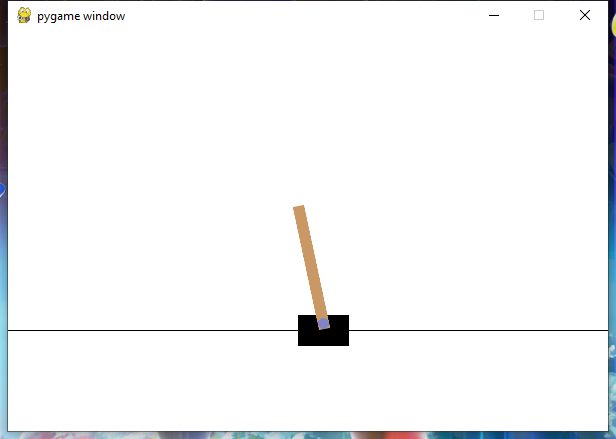

In [76]:
screenshot_save

# Lets look at what my agent learned from watching me play

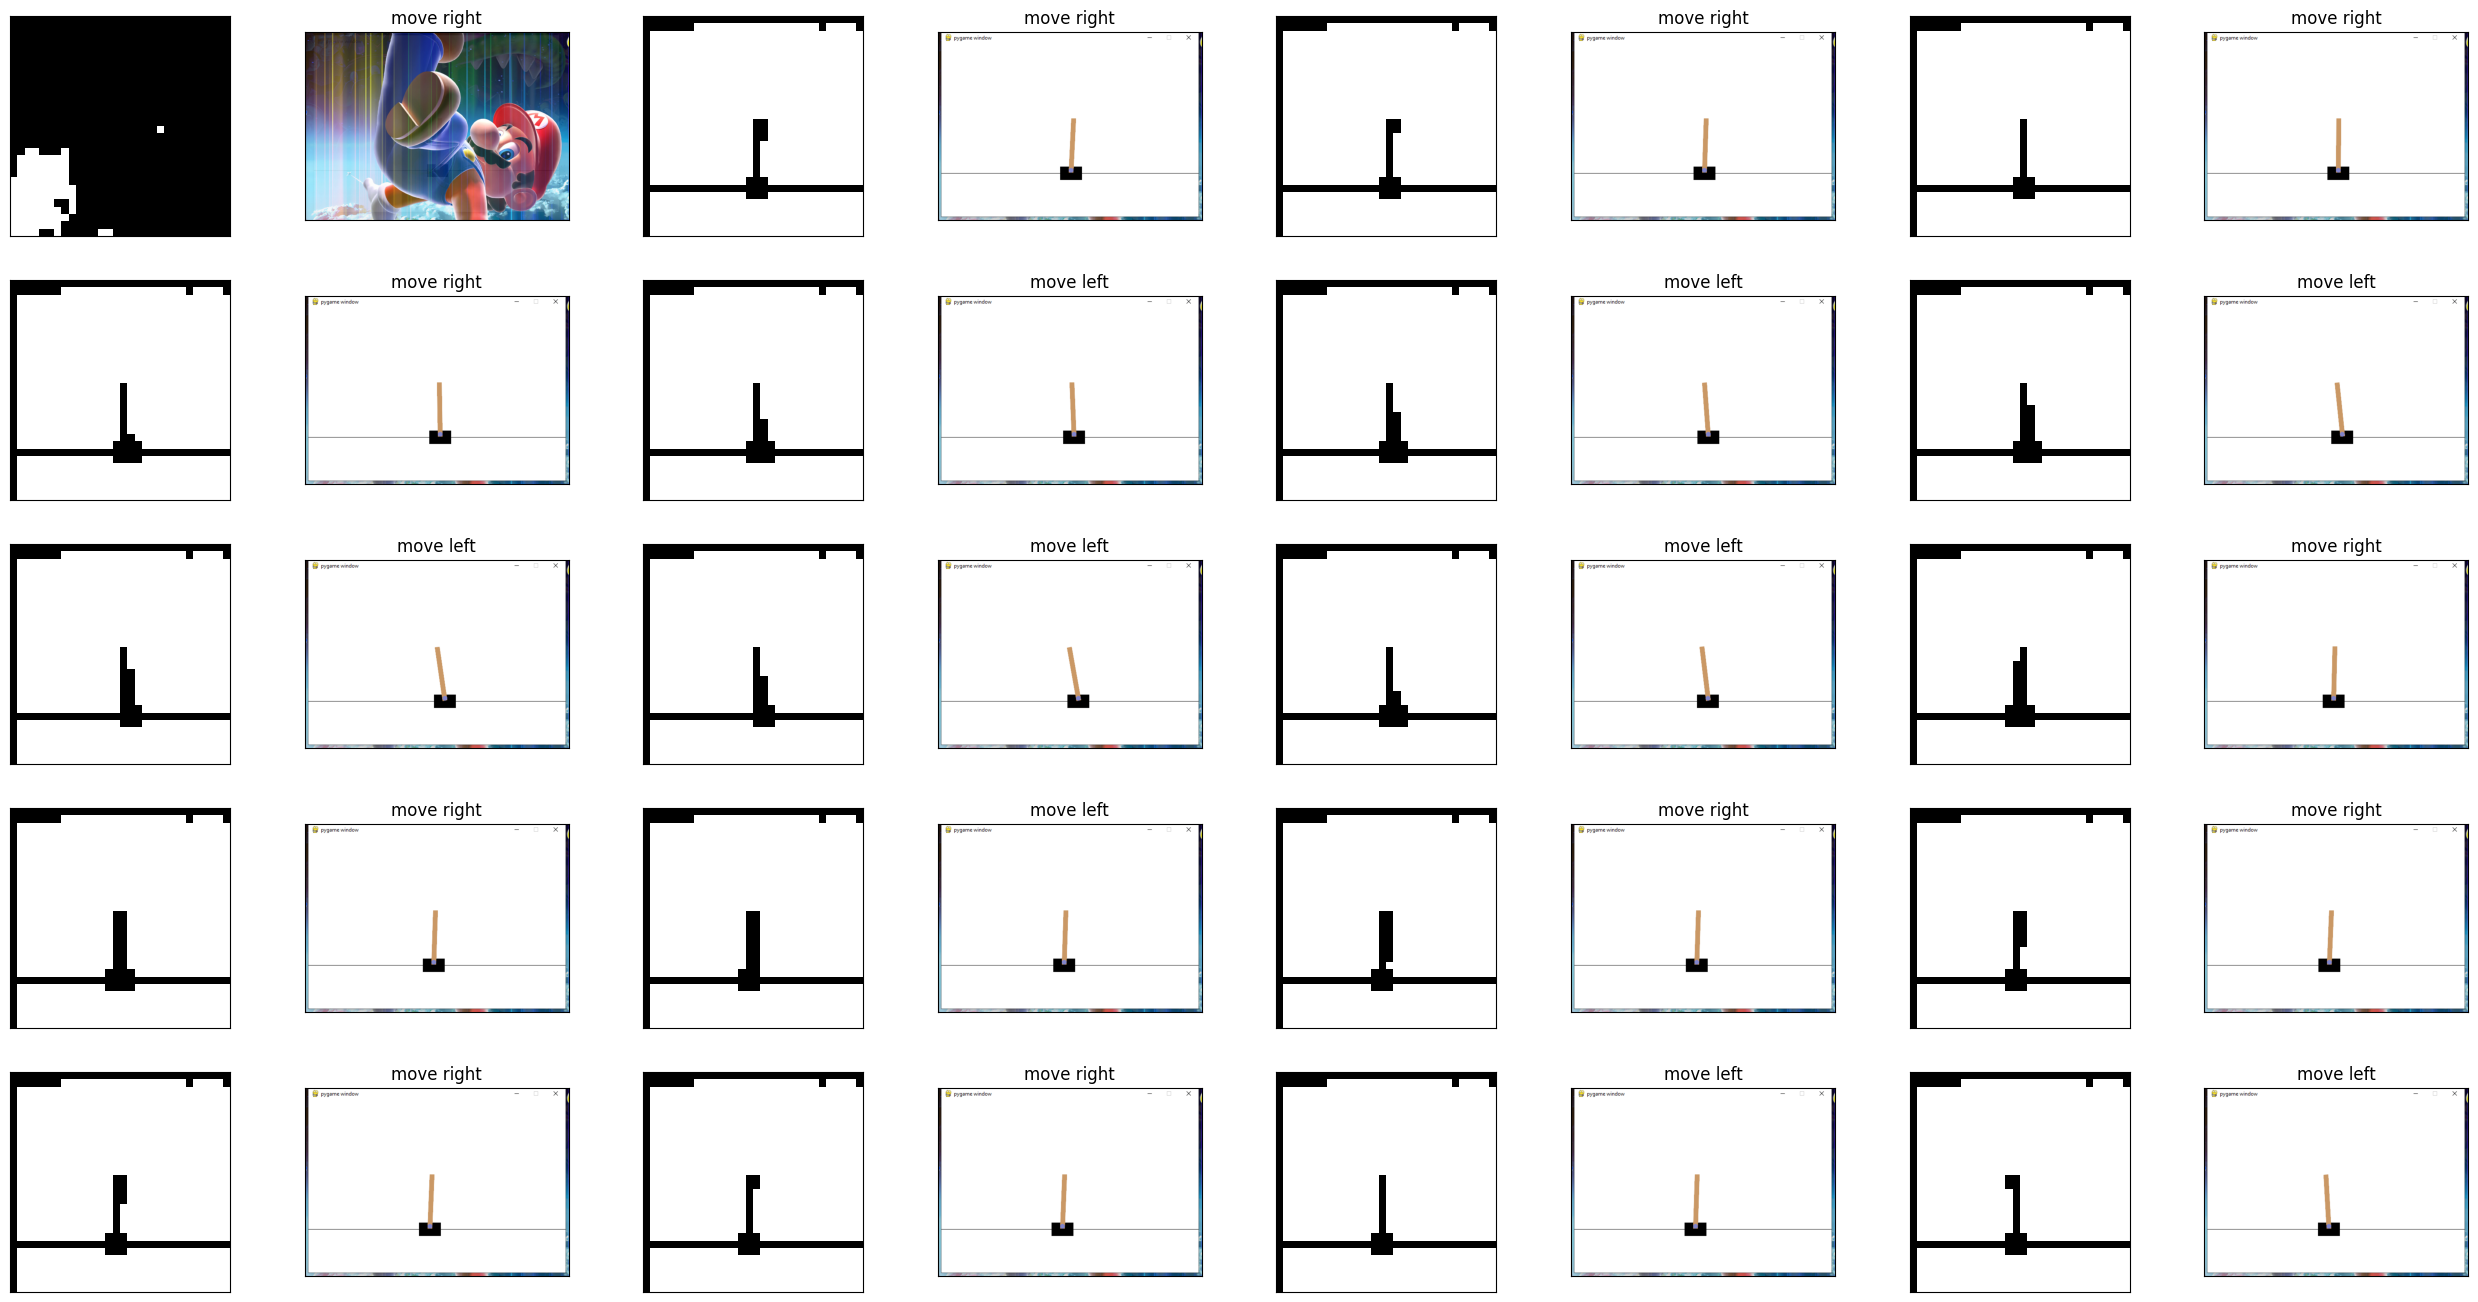

In [20]:
def visualize_binary_array2(binary_array, grid_size):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    array_2d = np.array(binary_array).reshape(-1, GRID_SIZE)
    plt.imshow(array_2d, cmap='Greys', interpolation='nearest')

def num_to_action(num):
    if num ==0:
        return 'left'
    else: return 'right' 


num_rows = 2
num_cols = 2
num_images = 20
plt.figure(figsize=(32, 20))

for i in range(num_images):
    plt.subplot(3*num_rows, 4*num_cols, 2*i+1)
    visualize_binary_array2(agent.state_array[i][0], GRID_SIZE)

    plt.subplot(3*num_rows, 4*num_cols, 2*i+2)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(agent.image_array[i])
    plt.title(f'move {num_to_action(agent.state_array[i][1])}')
plt.show()

# Show the plot

#### we can see the state on the left and the original image on the right. you can also see the action it should take (which it learned with imitation learning). To make it better I just have to give it more data (play more myself so it can learn more). also to make it smarter it would be usefull to give it an state collection instead of just a state. because then it can see how the cart is moving.